# 미션 난이도(상)-1 실습

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
import gc
from PIL import Image

import torch
import torchvision
import torchvision.transforms as T
from torchsummary import summary

from sklearn.metrics import accuracy_score

## Data load
- CustomDataset에 익숙해지기 위해 torchvision이 아닌 tensorflow를 사용하여 데이터를 가져온다.
- 이미지를 tensor형태로 변환

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [3]:
print(len(train_images))
print(len(test_images))

60000
10000


## CustomDataset

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transforms):
        super().__init__()

        self.data = list()
        l = len(images)
        for i in range(l):
            self.data.append((transforms(images[i]), labels[i]))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, label = self.data[idx]

        return image, label

In [5]:
transforms = T.Compose([
    T.ToTensor()
])

train_dataset = CustomDataset(train_images, train_labels, transforms)
test_dataset = CustomDataset(test_images, test_labels, transforms)

60000


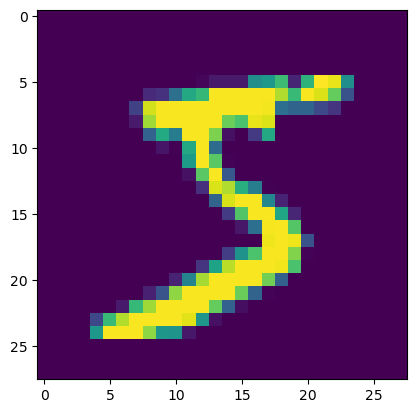

In [6]:
print(len(train_dataset))
plt.imshow(train_dataset[0][0].permute(1, 2, 0))

In [7]:
train_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [8]:
# train, valid data split

total_num = len(train_dataset)
train_num, valid_num = int(total_num*0.8), int(total_num*0.2)

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num])

## DataLoader

In [9]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
print(len(train_dataloader))
print(len(valid_dataloader))
print(len(test_dataloader))

1500
375
313


## Model 생성
- Flatten, FC layer 없이 구현
- Flatten : 1 by 1 convolution으로 구현
- Fc layer는..?

In [11]:
class CNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.layer = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1),
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.ReLU(True),
            torch.nn.AdaptiveAvgPool2d(output_size=1), # feature map의 크기가 1by1이 된다.
            torch.nn.Conv2d(in_channels=32, out_channels=num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.layer(x)
        output = x.view(x.size(0), -1)
        return output

In [12]:
model_test = CNN(10)
summary(model_test, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
         MaxPool2d-4           [-1, 16, 28, 28]               0
            Conv2d-5           [-1, 32, 28, 28]           4,640
       BatchNorm2d-6           [-1, 32, 28, 28]              64
              ReLU-7           [-1, 32, 28, 28]               0
 AdaptiveAvgPool2d-8             [-1, 32, 1, 1]               0
            Conv2d-9             [-1, 10, 1, 1]             330
Total params: 5,226
Trainable params: 5,226
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.96
Params size (MB): 0.02
Estimated Total Size (MB): 0.98
-----------------------------------------------

## model 학습, 검증 함수

In [13]:
def training(model, train_dataloader, train_dataset, criterion, optimizer):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, valid_dataloader, valid_dataset, criterion):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    tbar = tqdm(valid_dataloader)
    for images, labels in tbar:
        outputs = model(images)
        loss = criterion(outputs, labels)

        valid_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        valid_accuracy += (predicted == labels).sum().item()

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

def train_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print(epoch+1)
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')
        print(f'Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

    return model

In [14]:
model = CNN(10)
criterion = torch.nn.CrossEntropyLoss() # LogSoftmax를 사용하지 않았기에 CrossEntropyLoss 사용
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = train_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 10)

1


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 1.5246615560849508, Train Accuracy: 0.529375
Valid Loss: 1.1345377524693807, Valid Accuracy: 0.6766666666666666
2


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.9360115086634954, Train Accuracy: 0.7458541666666667
Valid Loss: 0.7524222657680512, Valid Accuracy: 0.7831666666666667
3


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.6901777019500732, Train Accuracy: 0.8142291666666667
Valid Loss: 0.677642292102178, Valid Accuracy: 0.7811666666666667
4


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.5559213945269584, Train Accuracy: 0.8496041666666667
Valid Loss: 0.4651448853413264, Valid Accuracy: 0.87525
5


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.47673227004210156, Train Accuracy: 0.87225
Valid Loss: 0.43191776156425477, Valid Accuracy: 0.873
6


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.41807106307148933, Train Accuracy: 0.8887291666666667
Valid Loss: 0.4921767200231552, Valid Accuracy: 0.8515833333333334
7


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.3765344982246558, Train Accuracy: 0.8996458333333334
Valid Loss: 0.4458464730580648, Valid Accuracy: 0.86175
8


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.34528753319879374, Train Accuracy: 0.907625
Valid Loss: 0.41748298799991607, Valid Accuracy: 0.8754166666666666
9


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.3182049298733473, Train Accuracy: 0.9144791666666666
Valid Loss: 0.4179969154795011, Valid Accuracy: 0.8659166666666667
10


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.29473489261666935, Train Accuracy: 0.9225416666666667
Valid Loss: 0.41627460952599843, Valid Accuracy: 0.86725


## test

In [15]:
test_loss = 0.0
test_accuracy = 0
all_pred = []
all_label = []

tbar = tqdm(test_dataloader)
for images, labels in tbar:
    outputs = model(images)
    loss = criterion(outputs, labels)

    test_loss += loss.item()
    max_prob, predicted = torch.max(outputs, 1)
    test_accuracy += (predicted == labels).sum().item()

    all_label.extend(labels.tolist())
    all_pred.extend(predicted.tolist())

test_loss = test_loss / len(test_dataloader)
test_accuracy = test_accuracy / len(test_dataset)

print(test_loss, test_accuracy)

  0%|          | 0/313 [00:00<?, ?it/s]

0.40853909810130207 0.8706


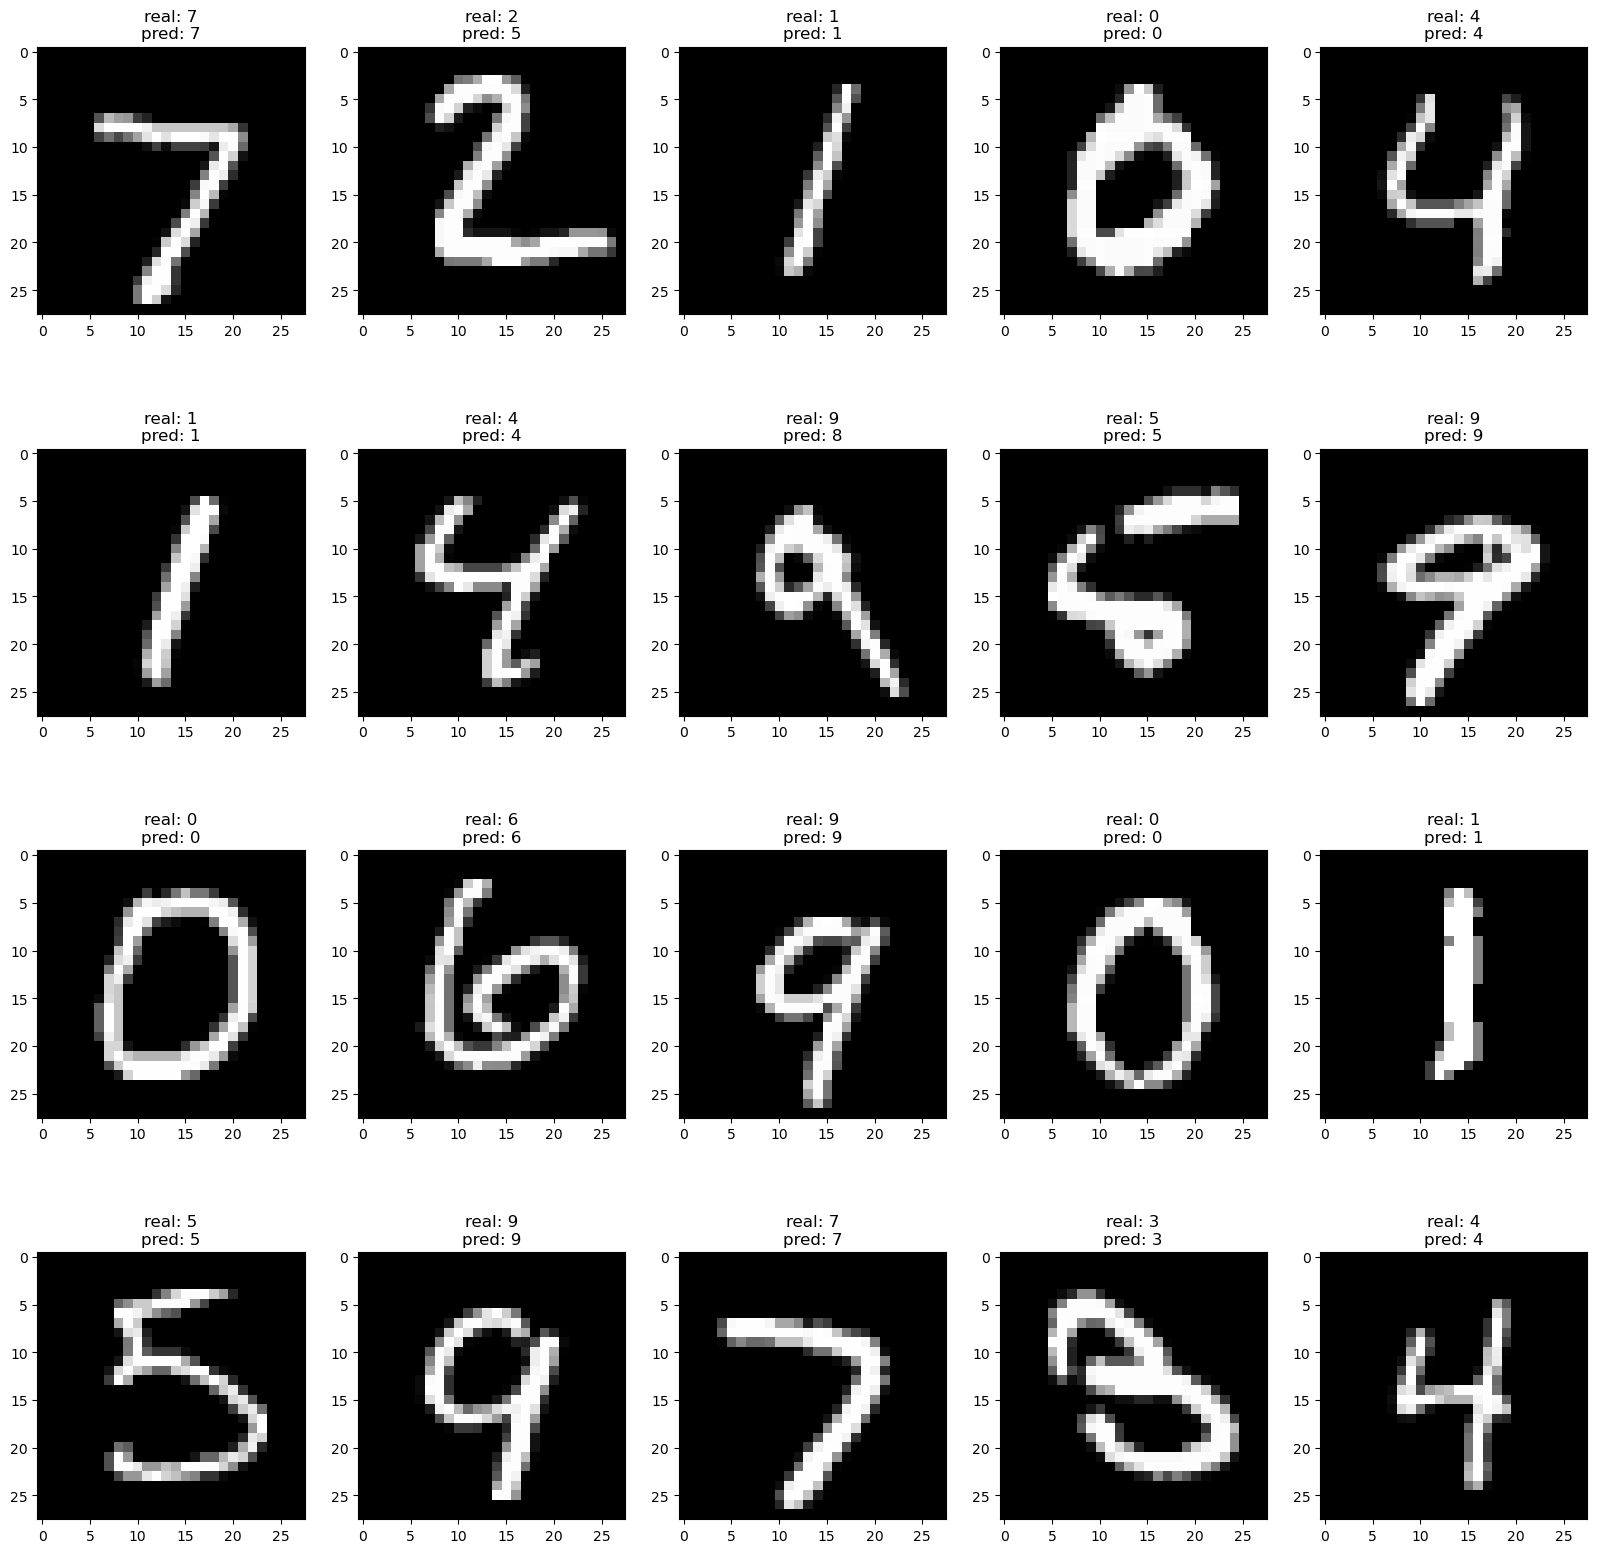

In [16]:
plt.figure(figsize=(20, 20))

for i in range(20):
    image = test_dataset[i][0].squeeze().numpy()
    label = all_label[i]
    pred = all_pred[i]
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f'real: {label}\npred: {pred}')